## Mishandra: Python

This notebook demonstrates how to save data to a Cassandra cluster and retrieve it back.

In [3]:
%load_ext autoreload
%autoreload 2

import sys, os, random
from IPython.display import display, Video
from PIL import Image
import numpy as np

mishandra_path = 'c:\\Users\\knma\\dev\\mishandra'
if mishandra_path not in sys.path:
    sys.path.insert(0, mishandra_path)

import mishandra

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Create a Mishandra session and print Cassandra keyspaces
**MishandraSession** class handles communication with Cassandra cluster and contains routines for data I/O.

Cassanra stores data in keyspaces. A keyspace is the top-level database object that controls replication.
Each keyspace can contain multiple tables.

A Mishandra **collection** is a bunch of data stored in Cassandra tables. A **collection** consists of multiple frames. For example, it could be a 3d mesh sequence with shared or not shared topology, a point cloud, a video splitted into images and audio chunks, or any other data sequence that have a suitable Mishandra interface. 

In [2]:
session = mishandra.MishandraSession()

# Don't show system keyspaces by default
session.print_keyspaces()

Mishandra session created

Keyspaces:
misha (durable_writes: True, replication: {'class': 'org.apache.cassandra.locator.SimpleStrategy', 'replication_factor': '3'})
   table misha_dog (rows: 0)



A session object provides a set of listed below functions for basic keyspace and collection manipulations.
#### Set an active keyspace. Create a keyspace if not exists
An active keyspace must be set for any further collection-related operations.

In [11]:
import mishandra

session.set_keyspace('misha')

Current keyspace: misha

Keyspaces:
misha (durable_writes: True, replication: {'class': 'org.apache.cassandra.locator.SimpleStrategy', 'replication_factor': '3'})



#### Delete a keyspace and its data if exists

In [10]:
session.delete_keyspace('misha')

Keyspace misha dropped

Keyspaces:
No user defined keyspaces


#### Create a collection if not exists
Collections are data agnostic. It means that a collection is not tied to data type and we can place there anything that was packed through a Mishandra interface.

In [12]:
session.create_collection('misha_dog')

Table misha.misha_dog

Keyspaces:
misha (durable_writes: True, replication: {'class': 'org.apache.cassandra.locator.SimpleStrategy', 'replication_factor': '3'})
   table misha_dog (rows: 0)



#### Delete a collection if exists

In [139]:
session.delete_collection('misha_dog')

Table misha.misha_dog dropped

Keyspaces:
misha (durable_writes: True, replication: {'class': 'org.apache.cassandra.locator.SimpleStrategy', 'replication_factor': '3'})



#### Clear a collection if exists

In [11]:
session.clear_collection('misha_dog')

Table misha.misha_dog truncated

Keyspaces:
misha (durable_writes: True, replication: {'class': 'org.apache.cassandra.locator.SimpleStrategy', 'replication_factor': '3'})
   table misha_dog (rows: 0)



#### Load a sequence of meshes from a directory of ```.obj``` files and visualize

In [13]:
# Make a list of meshes. Take all '.obj' files from a directory by default.
meshes = mishandra.trimesh.from_directory(
    os.path.join('..', 'test_data', 'pighead'),
    verbose=True
)

# Create a visualizer
renderer = mishandra.utils.OffscreenRenderer()

# Render meshes to a list of images
images = [renderer.update_scene(mesh).render()[0] for mesh in meshes]

# Make video from images and display
display(Video(mishandra.utils.make_video(images), embed=True))

16 meshes loaded (0001.obj..0016.obj)


#### Convert a sequence of meshes to proto frames

Mishandra converts data to intermediate protobuf representation. All the heavy proto fields are binary blobs, which gives fast access and compact storage. Protobuf objects and data sequence frames have one-to-one correspondence.

In [14]:
# Make a list of proto objects from meshes
protos = [mishandra.trimesh.make_proto(mesh, frame=i) for i, mesh in enumerate(meshes)]

# Pick a proto object and inspect its structure
mishandra.proto.print_fields(random.choice(protos))

Row
|  frame 10
|  name ''
|  description ''
|  scenes (1)
|  |  0:name ''
|  |  0:description ''
|  |  0:objects (1)
|  |  |  0:index 0
|  |  |  0:name 'object_from_timesh_000'
|  |  |  0:transform
|  |  |  |  name ''
|  |  |  0:pointSet
|  |  |  |  name ''
|  |  |  0:mesh
|  |  |  |  index 0
|  |  |  |  name ''
|  |  |  |  pointSet
|  |  |  |  |  name ''
|  |  |  |  |  P (3861) 15.08KB float32 (-1, 3)
|  |  |  |  |  N (3861) 15.08KB float32 (-1, 3)
|  |  |  |  |  Cd (3861) 15.08KB float32 (-1, 3)
|  |  |  |  |  Alpha (1287) 5.03KB float32 (-1, 1)
|  |  |  |  faces (7710) 30.12KB float32 (-1, 3)
|  |  |  0:camera
|  |  |  |  name ''
|  |  |  |  extrinsic
|  |  |  |  |  name ''
|  |  |  0:images (0)
|  |  |  0:imagesRaw (0)
byte fields total: 80.39KB


We could also pack all meshes into a single proto frame:

In [15]:
proto = mishandra.trimesh.make_proto(meshes, frame=0)

mishandra.proto.print_fields(proto, repeated_fields_limit=3)

Row
|  frame 0
|  name ''
|  description ''
|  scenes (1)
|  |  0:name ''
|  |  0:description ''
|  |  0:objects (16)
|  |  |  0:index 0
|  |  |  0:name 'object_from_timesh_000'
|  |  |  0:transform
|  |  |  |  name ''
|  |  |  0:pointSet
|  |  |  |  name ''
|  |  |  0:mesh
|  |  |  |  index 0
|  |  |  |  name ''
|  |  |  |  pointSet
|  |  |  |  |  name ''
|  |  |  |  |  P (534) 2.09KB float32 (-1, 3)
|  |  |  |  |  N (534) 2.09KB float32 (-1, 3)
|  |  |  |  |  Cd (534) 2.09KB float32 (-1, 3)
|  |  |  |  |  Alpha (178) 0.70KB float32 (-1, 1)
|  |  |  |  faces (1056) 4.12KB float32 (-1, 3)
|  |  |  0:camera
|  |  |  |  name ''
|  |  |  |  extrinsic
|  |  |  |  |  name ''
|  |  |  0:images (0)
|  |  |  0:imagesRaw (0)
|  |  |  1:index 0
|  |  |  1:name 'object_from_timesh_001'
|  |  |  1:transform
|  |  |  |  name ''
|  |  |  1:pointSet
|  |  |  |  name ''
|  |  |  1:mesh
|  |  |  |  index 0
|  |  |  |  name ''
|  |  |  |  pointSet
|  |  |  |  |  name ''
|  |  |  |  |  P (756) 2.95KB flo

#### Save proto frames to a Cassandra cluster

In [16]:
for proto in protos:
    session.save(collection='misha_dog', frame=proto.frame, proto=proto)

session.print_keyspaces()


Keyspaces:
misha (durable_writes: True, replication: {'class': 'org.apache.cassandra.locator.SimpleStrategy', 'replication_factor': '3'})
   table misha_dog (rows: 16)



#### Load proto frames from a Cassandra cluster
**MishandraSession.load** function loads all frames in range ```[frame_from..frame_to)``` into memory.

In [17]:
# Load protos from a collection
protos = session.load(collection='misha_dog', frame_from=0, frame_to=100)

16 rows loaded


 #### Make a sequence of meshes from proto frames and visualize

In [18]:
# Make a list of trimesh meshes from protos
meshes = [mishandra.trimesh.from_proto(proto) for proto in protos]

# Make video from images and display
images = [renderer.update_scene(mesh).render()[0] for mesh in meshes]
display(Video(mishandra.utils.make_video(images), embed=True))

#### Save a proto frame to file
It's also easy to save a proto frame to a binary file:

In [19]:
# Save the last frame in a sequence to file
session.save_to_file('dog.misha', protos[-1])

and to load a proto frame from file:

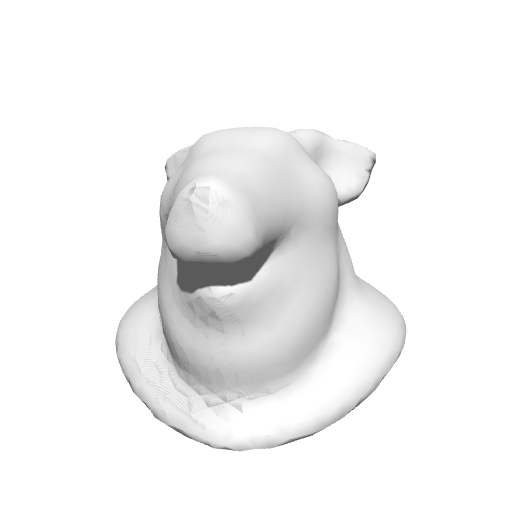

In [20]:
proto = session.load_from_file('dog.misha')

mesh = mishandra.trimesh.from_proto(proto)

image, _ = renderer.update_scene(mesh).render()
display(Image.fromarray(image[...,::-1]))

Mishandra saves and loads data in little endian order. No worries about hardware compatibility.